# <center> Improved Arrhythmia Classification Using Select  </center>
# <center>Morphological and Heart Rate Variability ECG Features. </center>
## <center> Mark James Dunbar </center>

<center>School of Electronic Engineering and Computer Science </center>
<center>Queen Mary University of London </center>
<center>London, United Kingdom </center>
<center>ec21896@qmul.ac.uk </center>

## <center> MSc Big Data Science - Final Project </center>



---

# <center>MSc Final Project Code Concept Exploration Notebook</center>



In this notebook, I will explore and experiment with several of the concepts introduced throughout the project. This notebook should be seen as a "playground" of sorts for testing and developing several of the algorithms implemented in the final experiment and pipeline notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Imports

In [ ]:
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from scipy.ndimage import label
from tqdm import tqdm, notebook
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.integrate import trapz

# Astropy
!pip install gatspy
from gatspy.periodic import LombScargleFast
from gatspy.periodic import LombScargle

def linebreak():
  print('________________________________________________________________________________')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Here we set up config for any plotting we're doing, I like to use Times New Roman to stay in line with the project's paper.

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Data Preprocessing

## Segment ECG records into 5-minute samples & generate segment classifications.

Segmenting ECGs into 5 minute intervals. This was for an earlier iteration of the model, which won't actually be used in the final pipeline.

In [ ]:
extract_to = "drive/MyDrive/data/ECG_extracted_data"

records = os.listdir(extract_to)

In [ ]:
def segment_ecg(records, mins):
  '''
  Function to segment ecgs into x-minute segments (from 30 min)
  '''

  segment_samples= 128 * mins * 60
  n_segments = 230400/segment_samples

  data_matrix = []
  labels_matrix = []


  for record in records:

    # Get the number of segments, and samples per segment
    
    # acquire the record
    ecg_record = pd.read_pickle(os.path.join(extract_to,record))
    signal = ecg_record['voltage'].tolist()
    labels = ecg_record['label'].tolist()

    i = 0

    while i < n_segments:

      start = (i)*segment_samples
      end = start + segment_samples
      segment = signal[start:end]

      label_segment = labels[start:end]
      labels = [l for l in label_segment if l not in ['N', '_']]

      label_counts, c = np.unique(labels, return_counts = True)

      if len(labels) == 0:
        classifier = 'N'
      else:
        classifier = label_counts[c == c.max()][0]

      data_matrix.append(segment)
      labels_matrix.append(classifier)      

      i += 1
  return np.array(data_matrix), np.array(labels_matrix)


## Create Data Matrices, Apply Train/Test Split

In [ ]:
# Apply Segmentation
x, y = segment_ecg(records, 5)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)

# Check Lengths
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

940
940
236
236


## Inspect Data


Looks like there is a massive class imbalance for normal beats, which is to be expected. This will have to be accounted for when training models. 

Training models that overfit is a pretty real issue here if we use accuracy as a quality metric - as the model can achieve an accuracy of ~87% by guessing that all classes are N! We therefore should look at a model performance metric like the F1 score to account for misclassification.

We also see that Fusion has one class. This is going to be an issue in model training. Perhaps there are not enough Fusion beat examples to train the model?

In [ ]:
train_labels = pd.DataFrame(y_train)
counts = train_labels.value_counts()
counts

N    811
V     84
S     44
F      1
dtype: int64

## Peak Detection Algorithm

In [ ]:
def detect_peaks(ecg_signal, peak_threshold=0.3, grouping_threshold=15):
  '''
  R Peak detection using cross correlation and thresholding template matching
  '''

  # Define our QRS filter - a simple sinewave
  t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
  qrs_filter = np.sin(t)

  # Normalize the data
  ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

  # Calculate the cross correlation similarity score
  similarity_score = np.correlate(ecg_signal, qrs_filter, mode="same")
  similarities = similarity_score / np.max(similarity_score)

  # return all found peaks using peak_threshold
  # one "beat" may have more than one indexed peak, so they msut be grouped
  peak_indexes = ecg_signal[similarities > peak_threshold].index

  # initialize output for grouped peaks
  output = np.empty(0)

  # Label groups of indexes that belong to the same R-peak
  peak_groups, num_groups = label(np.diff(peak_indexes) < grouping_threshold)

  # iterate through groups and take the mean as the R-peak index
  for i in np.unique(peak_groups)[1:]:
      peak_group = peak_indexes[np.where(peak_groups == i)]
      output = np.append(output, round(np.median(peak_group)))

  return output, similarities

## Example ECG reading 

Let's look at the ECG records we have for sampling

In [ ]:
print(os.listdir(extract_to))

['100', '103', '105', '106', '101', '108', '109', '111', '112', '113', '114', '115', '116', '118', '117', '123', '124', '121', '119', '122', '200', '201', '202', '203', '205', '208', '209', '212', '213', '210', '214', '215', '219', '220', '221', '222', '228', '230', '223', '231', '232', '233', '234', 'I01', 'I02', 'I06', 'I03', 'I05', 'I04', 'I07', 'I08', 'I10', 'I09', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I20', 'I21', 'I18', 'I19', 'I25', 'I22', 'I23', 'I24', 'I26', 'I27', 'I28', 'I29', 'I30', 'I34', 'I32', 'I33', 'I31', 'I35', 'I39', 'I38', 'I37', 'I36', 'I40', 'I41', 'I42', 'I44', 'I43', 'I45', 'I48', 'I49', 'I46', 'I47', 'I50', 'I54', 'I51', 'I52', 'I53', 'I55', 'I56', 'I57', 'I58', 'I59', 'I60', 'I62', 'I61', 'I63', 'I64', 'I65', 'I67', 'I66', 'I68', 'I69', 'I70', 'I73', 'I72', 'I71', 'I74', 'I75', '801', '802', '800', '803', '804', '806', '805', '807', '808', '810', '809', '811', '812', '820', '821', '822', '823', '824', '825', '827', '828', '826', '829', '840', '841'

Choose one to test peak detection on for 5 minutes of data

In [ ]:
ecg_record = pd.read_pickle(os.path.join(extract_to,'100'))

ecg_signal = ecg_record['voltage']
label_list = ecg_record['label']

# 5 mins
start = 0
stop = 128 * 60 * 5
x = ecg_signal[start:stop]
y = label_list[start:stop]

r_peaks, similarities = detect_peaks(x, peak_threshold=0.2)

Checking out the QRS-filter matching process for a few peaks in the sample ECG.

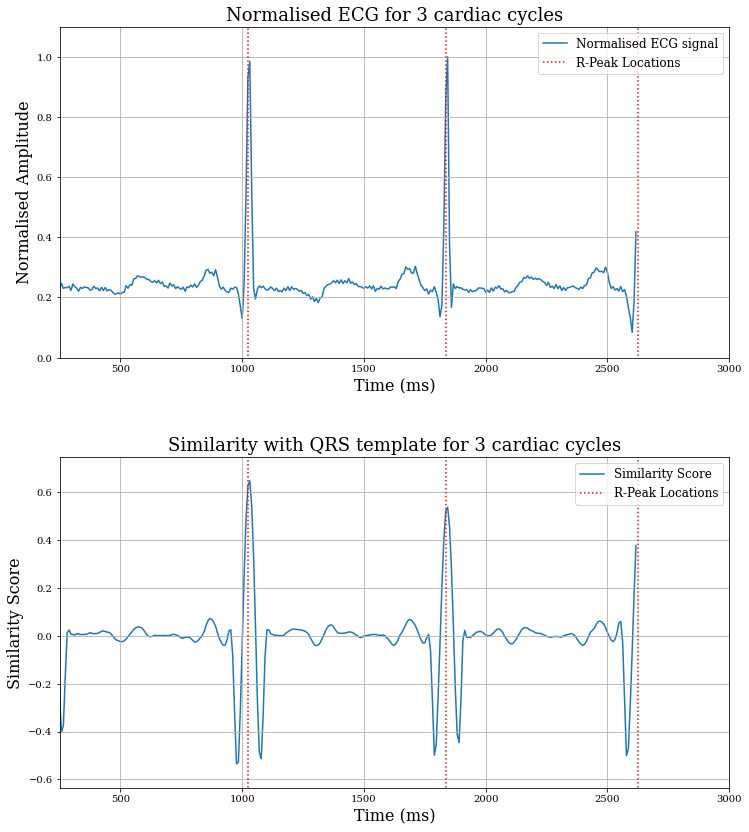

In [ ]:
def display_n_peaks(x, r_peaks, similarities, n_peaks=3):
  '''
  Show the first N peaks & their detected locations
  '''

  peaks = r_peaks[0:n_peaks]
  x_range = x[0:max(peaks.astype(int))]
  y_range = y[0:max(peaks.astype(int))]

  # We can see where ectopic beats occur
  ectopic_index = []
  for sample, value in enumerate(y_range):
    if value != 'N' and value != '_':
      ms_time = sample/128*1000
      ectopic_index.append(ms_time)

  similarities_range = similarities[0:max(peaks.astype(int))]

  # Convert samples to ms
  ms_list = []
  for sample, _ in enumerate(x_range):
    ms_time = sample/128*1000
    ms_list.append(ms_time)

  peak_locs_ms = []
  for _, peak in enumerate(peaks):
    ms_time = peak/128*1000
    peak_locs_ms.append(ms_time)

  normalised_x = (x_range - min(x_range)) / (max(x_range) - min(x_range))

  plt.figure(figsize=(12,14))
  plt.tight_layout()

  plt.subplot(211)
  plt.plot(ms_list, normalised_x, zorder=0, label='Normalised ECG signal')
  plt.vlines(peak_locs_ms, -1, 2, linestyles ="dotted", colors ="r", label="R-Peak Locations")
  plt.legend(prop={'size': 12})
  plt.ylim(min(normalised_x), max(normalised_x)+0.1)
  plt.xlim(250, 3000)
  plt.grid(True)
  plt.title(f"Normalised ECG for {n_peaks-1} cardiac cycles", fontsize=18)
  plt.xlabel("Time (ms)", fontsize=16)
  plt.ylabel("Normalised Amplitude", fontsize=16)

  plt.subplot(212)
  plt.plot(ms_list, similarities_range, zorder=0, label='Similarity Score')
  plt.vlines(peak_locs_ms, -1, 2, linestyles ="dotted", colors ="r", label="R-Peak Locations")
  plt.legend(prop={'size': 12})
  plt.ylim(min(similarities_range)-0.1, max(similarities_range)+0.1)
  plt.xlim(250, 3000)
  plt.grid(True)
  plt.title(f"Similarity with QRS template for {n_peaks-1} cardiac cycles", fontsize=18)
  plt.xlabel("Time (ms)", fontsize=16)
  plt.ylabel("Similarity Score", fontsize=16)

  plt.subplots_adjust(hspace=0.3)

  plt.show()

display_n_peaks(x, r_peaks, similarities, 4)

## Time-Domain Feature Extraction

In [ ]:
def get_td_features(r_peaks):

  '''
  Extract time-domain HRV features from the data
  '''

  td_results = []
  
  rr_vals = np.diff(r_peaks)
  rr_mean = np.mean(rr_vals)

  # Mean RR Interval (ms)
  rr_mean_ms = rr_mean*(128/100)
  td_results.append(rr_mean_ms)

  # Get Heartrates 
  heart_rates = 6000/rr_vals*(128/100)

  # Mean HR (Kubios' style) (BPM)
  k_heart_rate = 6000/rr_mean*(128/100)
  td_results.append(k_heart_rate)

  # Mean HR (BPM)
  heart_rate = np.mean(heart_rates)
  td_results.append(heart_rate)

  # STD HR (BPM)
  std_hr = np.std(heart_rates)
  td_results.append(std_hr)
 
  # MIN HR (BPM)
  min_hr = np.min(heart_rates)
  td_results.append(min_hr)

  # MAX HR (BPM)
  max_hr = np.max(heart_rates)
  td_results.append(max_hr)

  # RMSSD (ms)
  rmssd = np.sqrt(np.mean(np.square(rr_vals)))
  td_results.append(rmssd)
  
  # nn50 
  nnxx = np.sum(np.abs(np.diff(rr_vals)) > 50)*1
  td_results.append(nnxx)

  # pnn50 
  pnnxx = 100 * np.sum((np.abs(np.diff(rr_vals)) > 50)*1) / len(rr_vals)
  td_results.append(pnnxx)

  return td_results

In [ ]:
results = get_td_features(r_peaks)
print(results)

## Frequency-Domain Feature Extraction using Lomb's Periodigram


In [ ]:
rr_vals = np.diff(r_peaks)

g = np.cumsum(rr_vals) / 1000.0
f = interp1d(g, rr_vals, kind='cubic')



In [ ]:
# sample rate for interpolation
fs = 500
steps = 1 / fs

# now we can sample from interpolation function
xx = np.arange(1, np.max(g), steps)
rr_interpolated = f(xx)

In [ ]:
# import scipy.signal as signal

!pip install astropy
from astropy.stats import LombScargle

fxx, pxx = LombScargle(np.arange(len(rr_vals), dtype=float), rr_vals, center_data=True).autopower(normalization='psd', samples_per_peak=1, nyquist_factor=1, method='cython')

'''
Segement found frequencies in the bands 
  - Very Low Frequency (VLF): 0-0.04Hz 
  - Low Frequency (LF): 0.04-0.15Hz 
  - High Frequency (HF): 0.15-0.4Hz
'''

cond_vlf = (fxx >= 0) & (fxx < 0.04)
cond_lf = (fxx >= 0.04) & (fxx < 0.15)
cond_hf = (fxx >= 0.15) & (fxx < 0.4)

# calculate power in each band 
vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
lf = trapz(pxx[cond_lf], fxx[cond_lf])
hf = trapz(pxx[cond_hf], fxx[cond_hf])

# total power
total_power = vlf + lf + hf

# frequency with the most power in each band
peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

# lf and hf fractions
lf_nu = 100 * lf / (lf + hf)
hf_nu = 100 * hf / (lf + hf)

results = {}
results['Power VLF (ms2)'] = vlf
results['Power LF (ms2)'] = lf
results['Power HF (ms2)'] = hf   
results['Power Total (ms2)'] = total_power

results['LF/HF'] = (lf/hf)
results['Peak VLF (Hz)'] = peak_vlf
results['Peak LF (Hz)'] = peak_lf
results['Peak HF (Hz)'] = peak_hf

results['Fraction LF (nu)'] = lf_nu
results['Fraction HF (nu)'] = hf_nu

for k, v in results.items():
    print("* %s: %.10f" % (k, v))

plt.figure(figsize=(15, 10))
plt.plot(fxx, pxx, color="k", linewidth=1)
plt.title("Lomb's Periodogram", fontsize=25)

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0.0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, 2500, alpha=0.4, color="#2CBDFE", label="VLF Band (0 - 0.04 Hz)")
plt.gca().fill_between(x_lf, 2500, alpha=0.4, color="#F3A0F2", label="LF Band (0.04 - 0.15 Hz)")
plt.gca().fill_between(x_hf, 2500, alpha=0.4, color="#F5B14C", label="HF Band (0.15 - 0.4 Hz)")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Power Spectral Density", fontsize=20)
#plt.ylim(0, 0.125)
plt.legend(fontsize=20)
plt.show()

## Testing FDD Method for Feature Extraction

In [ ]:
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(g, rr_vals, color="k", markerfacecolor="#2CBDFE", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 20)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx, rr_interpolated, color="k", markerfacecolor="#9D2EC5", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 20)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [ ]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    # Append Results
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [ ]:
# Print the FD metrics
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

# Print the results
for k, v in results.items():
    print("- %s: %.2f" % (k, v))

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("Power Spectral Density (PSD) Plot (Lomb's periodogram)", fontsize=25)

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.4, color="#2CBDFE", label="VLF Band (0 - 0.04 Hz)")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.4, color="#F3A0F2", label="LF Band (0.04 - 0.15 Hz)")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.4, color="#F5B14C", label="HF Band (0.15 - 0.4 Hz)")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Power Spectral Density (mV$^{2}$/Hz)", fontsize=20)
plt.ylim(0, 300)
plt.legend(fontsize=20)
plt.show()

In [ ]:
def get_fd_features(r_peaks):

  '''
  Extract frequency-domain HRV features from the data
  '''

  fd_results = []

  rr_vals = np.diff(r_peaks)

  g = np.cumsum(rr_vals) / 1000.0
  f = interp1d(g, rr_vals, kind='cubic', fill_value='extrapolate')

  # sample rate for interpolation
  fs = 4
  steps = 1 / fs

  # now we can sample from interpolation function
  xx = np.arange(1, np.max(g), steps)
  rr_interpolated = f(xx)

  # Estimate the spectral density using Welch's method
  fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)

  vlf_range = (fxx >= 0) & (fxx < 0.04)
  lf_range = (fxx >= 0.04) & (fxx < 0.15)
  hf_range = (fxx >= 0.15) & (fxx < 0.4)
  
  # calculate power in each band by integrating the spectral density 
  vlf = trapz(pxx[vlf_range], fxx[vlf_range])
  fd_results.append(vlf)

  lf = trapz(pxx[lf_range], fxx[lf_range])
  fd_results.append(lf)

  hf = trapz(pxx[hf_range], fxx[hf_range])
  fd_results.append(hf)
  
  # sum these up to get total power
  total_power = vlf + lf + hf
  fd_results.append(total_power)

  # lf to hf fraction
  fd_results.append(lf/hf)

  if len(pxx[vlf_range])> 1:
    # find which frequency has the most power in each band
    peak_vlf = fxx[vlf_range][np.argmax(pxx[vlf_range])]
    fd_results.append(peak_vlf)
  elif len(pxx[vlf_range])> 0: 
    peak_vlf = pxx[vlf_range][0]
    fd_results.append(peak_vlf)
  else:
    peak_vlf = 0
    fd_results.append(peak_vlf)

  # peak_lf = fxx[lf_range][np.argmax(pxx[lf_range])]
  # fd_results.append(peak_lf)
  if len(pxx[lf_range])> 1:
    # find which frequency has the most power in each band
    peak_lf = fxx[lf_range][np.argmax(pxx[lf_range])]
    fd_results.append(peak_lf)
  elif len(pxx[lf_range])> 0: 
    peak_lf = pxx[lf_range][0]
    fd_results.append(peak_lf)
  else:
    peak_lf = 0
    fd_results.append(peak_lf)

  # peak_hf = fxx[hf_range][np.argmax(pxx[hf_range])]
  # fd_results.append(peak_hf)
  if len(pxx[hf_range])> 1:
    # find which frequency has the most power in each band
    peak_hf = fxx[hf_range][np.argmax(pxx[hf_range])]
    fd_results.append(peak_hf)
  elif len(pxx[hf_range])> 0: 
    peak_hf = pxx[hf_range][0]
    fd_results.append(peak_hf)
  else:
    peak_hf = 0
    fd_results.append(peak_hf)

  # fraction of lf and hf
  lf_nu = 100 * lf / (lf + hf)
  fd_results.append(lf_nu)

  hf_nu = 100 * hf / (lf + hf)     
  fd_results.append(hf_nu)

  return fd_results

In [ ]:
results = get_fd_features(r_peaks)
print(results)

## Extracting All Features

In [ ]:
def extract_features(r_peaks):

  td_features = get_td_features(r_peaks)
  fd_features = get_fd_features(r_peaks)

  features = td_features + fd_features

  return features
  # should be len 16

In the code below, there are some cases where less than 3 r-peaks are detected. This will be fixed later when we choose an appropriate peak detection threshold.

In [ ]:
features_matrix = []
failures = []

for index, ecg_record in tqdm(enumerate(x_train)):

  ecg_record = pd.Series(ecg_record)

  r_peaks, similarities = detect_peaks(ecg_record, peak_threshold=0.3)

  if len(r_peaks) < 3:
    print(f" Failure on index {index}")
    failures.append(index)

  else:
    features = extract_features(r_peaks)
    features_matrix.append(features)

## Checking out the features extracted from the training data

Checking out the Training data shape

In [ ]:
print(x_train.shape)
print(y_train.shape)

Checking out the labels dataframe containing the labels for every heartbeat in the training dataset

In [ ]:
y_train = pd.DataFrame(y_train, columns = ['Label'])
y_train

Producing a dataframe, X, of the extracted features

In [ ]:
columns = [
           'Mean RR Interval (ms)',
           'Kubios Mean HR (BPM)',
           'Mean HR (BPM)',
           'HR Standard Deviation (BPM)',
           'Min HR (BPM)',
           'Max HR (BPM)',
           'RMSSD (ms)',
           'nn50',
           'pnn50',
           'VLF Power',
           'LF Power',
           'HF Power',
           'Total Power',
           'LF/HF Fract',
           'Peak VLF',
           'Peak LF',
           'Peak HF',
           'LF Fract',
           'HF Fract',
]

x_train = pd.DataFrame(features_matrix, columns = columns)

Data types for each of the feature columns of X

In [ ]:
x_train.dtypes

Checking out the HRV features dataframe produced for each heartbeat in the training dataset

In [ ]:
x_train.head()

Did we get any NANs? If so, we'll fix this in the final pipeline.

In [ ]:
nans = np.where(np.isnan(x_train).any(axis=1))[0].tolist()
print(nans)